![image.png](https://i.imgur.com/a3uAqnb.png)

# Day 1: Exploring Food Images - EDA, Dimensionality Reduction & Clustering

Welcome! In this notebook, we'll embark on an exploratory journey with a food image dataset. Our goal is not to build a supervised classifier (like in the CIFAR-10 example), but rather to understand the dataset's structure using unsupervised learning techniques.

We will cover:
1.  **Loading and Initial Exploration (EDA):** Getting familiar with the dataset, its classes, and visualizing some samples.
2.  **Data Preprocessing:** Preparing the images (resizing, flattening, scaling) for machine learning algorithms.
3.  **Dimensionality Reduction:** Reducing the high-dimensional image data to a lower-dimensional space to make it easier to work with and visualize. We'll look at PCA, UMAP, t-SNE, and Kernel PCA.
4.  **Clustering:** Grouping similar images together using K-Means clustering on the reduced features and visualizing the results.

Let's start by importing necessary libraries and loading the dataset.


In [ ]:
%pip install fsspec==2023.6.0

In [4]:
from datasets import load_dataset
import kagglehub
from datasets import load_from_disk
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA
import random


## 1. Dataset Loading and Initial Setup


In [5]:
path = kagglehub.dataset_download("mohammad2012191/food-data")
print("Path to dataset files:", path)
!cp -r "/kaggle/input/food-data" "/content/data"

Path to dataset files: /kaggle/input/food-data


In [6]:
ds = load_from_disk("/content/data/data-food-classification/processed")
print(ds)
train_ds = ds["train"]
valid_ds = ds["valid"]
print(train_ds[0])       # first example
print(train_ds.features) # schema, including your image column, label column, etc.


DatasetDict({
    train: Dataset({
        features: ['image', 'target'],
        num_rows: 1050
    })
    valid: Dataset({
        features: ['image', 'target'],
        num_rows: 350
    })
})
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=308x512 at 0x7D53D09CC390>, 'target': 0}
{'image': Image(decode=True, id=None), 'target': ClassLabel(names=['apple_pie', 'falafel', 'french_toast', 'ice_cream', 'ramen', 'sushi', 'tiramisu'], id=None)}


## 2. Exploratory Data Analysis (EDA)

Before diving into complex processing, let's explore the dataset. We'll check:
- The distribution of labels (classes) in the training and validation sets.
- The unique label names and the total number of classes.
- Sample images from each class.
- Basic properties of the images (like size and mode).

In [ ]:
# Get unique labels from both train and validation
train_labels_list = [item['target'] for item in ds['train']]
val_labels_list = [item['target'] for item in ds['valid']]

In [ ]:
print("Train label distribution:")
print(Counter(train_labels_list))

print("Validation label distribution:")
print(Counter(val_labels_list))

In [ ]:
# Get unique label names
unique_labels = sorted(list(set(train_labels_list + val_labels_list)))
print(f"Unique labels: {unique_labels}")
print(f"Number of classes: {len(unique_labels)}")

### 2.1 Visualizing Sample Images

Let's define a function to display a few sample images for each food category to get a visual sense of the data.

In [ ]:
def plot_samples_by_label(dataset, dataset_name, samples_per_label=3):
    """Plot sample images for each label"""

    # Group images by label
    label_to_images = {}
    for i, item in enumerate(dataset):
        label = item['target']
        if label not in label_to_images:
            label_to_images[label] = []
        label_to_images[label].append((i, item['image']))

    # Create subplots
    n_labels = len(label_to_images)
    fig, axes = plt.subplots(n_labels, samples_per_label,
                             figsize=(samples_per_label * 3, n_labels * 3))

    if n_labels == 1:
        axes = axes.reshape(1, -1)

    fig.suptitle(f'{dataset_name} Dataset - Sample Images by Label', fontsize=16)

    for label_idx, (label, images) in enumerate(sorted(label_to_images.items())):
        # Take first few samples for this label
        sample_images = images[:samples_per_label]

        for img_idx, (orig_idx, image) in enumerate(sample_images):
            ax = axes[label_idx, img_idx]
            ax.imshow(image)
            ax.set_title(f'Label: {label}\nIndex: {orig_idx}')
            ax.axis('off')

        # Fill empty subplots if not enough samples
        for img_idx in range(len(sample_images), samples_per_label):
            axes[label_idx, img_idx].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
# Plot samples from training set
plot_samples_by_label(ds['train'], 'Training', samples_per_label=3)

In [ ]:
# Plot samples from validation set
plot_samples_by_label(ds['valid'], 'Validation', samples_per_label=3)

In [ ]:
# Check image properties from first few samples
print(f"Sample image properties:")
for i in range(min(3, len(ds['train']))):
    img = ds['train'][i]['image']
    print(f"Image {i}: Size = {img.size}, Mode = {img.mode}")

## 3. Data Preprocessing

To use these images with dimensionality reduction and clustering algorithms, we need to preprocess them:
1.  **Resize:** Ensure all images have a consistent size.
2.  **Convert to Array & Flatten:** Convert PIL images to NumPy arrays and then flatten them into 1D vectors.
3.  **Normalize:** Scale pixel values (typically to the 0-1 range).
4.  **Combine & Scale:** Combine training and validation images and then apply feature scaling (e.g., `StandardScaler`).
    - Why do you think we combine them?

In [5]:
TARGET_SIZE = (128, 128)  # Resize all images to this size
N_COMPONENTS = 50

In [29]:
def preprocess_images_and_labels(dataset, dataset_name):
    """
    Preprocess images: resize, convert to arrays, flatten
    Keep track of labels
    """
    images = []
    labels = []

    print(f"Processing {dataset_name} set...")

    for i, item in enumerate(dataset):
        if i % 100 == 0:
            print(f"  Processed {i}/{len(dataset)} images")

        # Get image and label
        img = item['image']
        label = item['target']

        # Resize image
        img_resized = img.resize(TARGET_SIZE)

        # Convert to numpy array and normalize to 0-1
        img_array = np.array(img_resized) / 255.0

        # Flatten the image (height * width * channels)
        img_flattened = img_array.flatten()


        images.append(img_flattened)
        labels.append(label)

    print(f"  Completed processing {len(images)} images")
    return np.array(images), np.array(labels)

In [30]:
train_images, train_labels = preprocess_images_and_labels(ds['train'], 'Training')
val_images, val_labels = preprocess_images_and_labels(ds['valid'], 'Validation')

Processing Training set...
  Processed 0/1050 images
  Processed 100/1050 images
  Processed 200/1050 images
  Processed 300/1050 images
  Processed 400/1050 images
  Processed 500/1050 images
  Processed 600/1050 images
  Processed 700/1050 images
  Processed 800/1050 images
  Processed 900/1050 images
  Processed 1000/1050 images
  Completed processing 1050 images
Processing Validation set...
  Processed 0/350 images
  Processed 100/350 images
  Processed 200/350 images
  Processed 300/350 images
  Completed processing 350 images


In [31]:
print(f"Training images shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Validation images shape: {val_images.shape}")
print(f"Validation labels shape: {val_labels.shape}")

Training images shape: (1050, 49152)
Training labels shape: (1050,)
Validation images shape: (350, 49152)
Validation labels shape: (350,)


### 3.1 Combining and Scaling Data

We'll combine the preprocessed training and validation images for dimensionality reduction and clustering. Then, we'll scale the features using `StandardScaler` to ensure each feature contributes equally to the distance computations in PCA and K-Means.

In [32]:
all_images = np.vstack([train_images, val_images])
all_labels_combined = np.concatenate([train_labels, val_labels])

In [33]:
scaler = StandardScaler()
all_images_scaled = scaler.fit_transform(all_images)

## 4. Dimensionality Reduction

Image data is high-dimensional (e.g., 128x128x3 = 49,152 features per image). Dimensionality reduction techniques help to:
- Reduce computational complexity.
- Mitigate the "curse of dimensionality."
- Potentially improve the performance of subsequent algorithms by removing noise.
- Enable visualization in 2D or 3D. (If needed)
We'll explore several techniques. Note that in this notebook, each subsequent technique is applied to the *scaled original data*, and the variable `all_images_reduced` will be updated. The final clustering will use the output of the last applied dimensionality reduction method. Of course you can mitigate this if you run only the reduction technique you want


### 4.1 Principal Component Analysis (PCA)
PCA is a linear technique that projects data onto a lower-dimensional subspace while preserving as much variance as possible.

In [34]:
# Apply PCA
print(f"Applying PCA with {N_COMPONENTS} components...")
pca = PCA(n_components=50)
all_images_reduced = pca.fit_transform(all_images_scaled)
print(f"Original feature dimension: {all_images.shape[1]}")
print(f"Explained variance ratio (first 10 components): {pca.explained_variance_ratio_[:10]}")
print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.3f}")
print(f"Shape after PCA: {all_images_reduced.shape}")

Applying PCA with 50 components...
Original feature dimension: 49152
Explained variance ratio (first 10 components): [0.15219297 0.09331802 0.06174221 0.03605981 0.03420244 0.03280266
 0.02573449 0.02409904 0.01864219 0.01527851]
Total explained variance: 0.716
Shape after PCA: (1400, 50)


### 4.2 Uniform Manifold Approximation and Projection (UMAP)
UMAP is a non-linear dimensionality reduction technique effective for visualizing clusters and preserving both local and global structure of the data.

In [41]:
print(f"Applying UMAP with 2 components...")
reducer_umap = umap.UMAP(n_components=2,
                         n_neighbors=15,  # Default is 15, controls local vs global structure
                         min_dist=0.1,  # Default is 0.1, controls how tightly points are packed
                         random_state=42)
all_images_reduced = reducer_umap.fit_transform(all_images_scaled)

Applying UMAP with 50 components...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


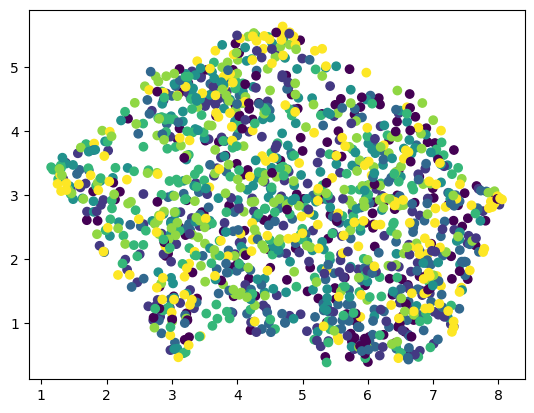

In [42]:
plt.scatter(all_images_reduced[:,0],all_images_reduced[:,1], c=all_labels_combined)

### 4.3 t-Distributed Stochastic Neighbor Embedding (t-SNE)
t-SNE is another non-linear technique particularly good at visualizing high-dimensional datasets in low dimensions (typically 2D or 3D) by revealing local structure and clusters.
*Note: t-SNE can be computationally intensive for large datasets and many components.*

In [59]:
print(f"Applying t-SNE with 2 components...")
tsne = TSNE(n_components=2,
            perplexity=30,  # Common default, try values between 5 and 50
            n_iter=1000,  # At least 250, more can be better
            random_state=42,
            n_jobs=-1)  # Use all available cores
all_images_reduced = tsne.fit_transform(all_images_scaled)
print(f"Shape after t-SNE: {all_images_reduced.shape}")

Applying t-SNE with 2 components...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Shape after t-SNE: (1400, 2)


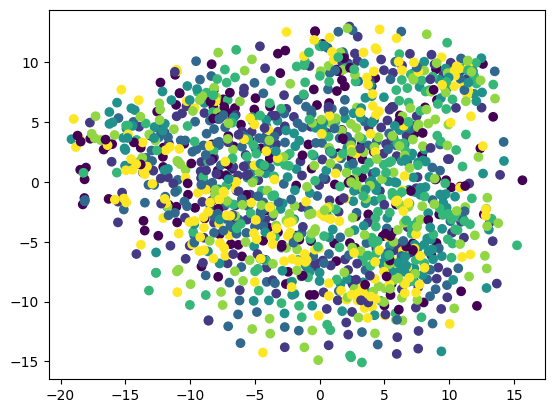

In [44]:
plt.scatter(all_images_reduced[:,0],all_images_reduced[:,1], c=all_labels_combined)

### 4.4 Kernel PCA (KPCA)
Kernel PCA extends PCA to non-linear dimensionality reduction by using kernel functions to project data into a higher-dimensional space where linear separation might be possible, before applying PCA.

In [45]:
print(f"Applying Kernel PCA with {N_COMPONENTS} components...")
# Common kernels: 'linear', 'poly', 'rbf', 'sigmoid', 'cosine'
# 'gamma' is a key parameter for 'rbf', 'poly', 'sigmoid'
kpca = KernelPCA(n_components=N_COMPONENTS,
                 kernel="rbf",  # Radial Basis Function kernel is common
                 gamma=None,  # If None, defaults to 1/n_features
                 random_state=42,
                 fit_inverse_transform=False)
all_images_reduced = kpca.fit_transform(all_images_scaled)
print(f"Shape after Kernel PCA: {all_images_reduced.shape}")

Applying Kernel PCA with 50 components...
Shape after Kernel PCA: (1400, 50)


## 5. Clustering with K-Means and Visualization

After reducing the dimensionality of our image features, we can apply clustering algorithms to group similar images. We'll use K-Means, a popular partitioning algorithm.

We'll define a function to:
1.  Perform K-Means clustering.
2.  Visualize random sample images from each discovered cluster.
3.  Display the true label distribution within each cluster to see how well the unsupervised clustering aligns with the actual food categories.

In [48]:
def perform_clustering_and_visualize(features, true_labels, n_clusters, title_suffix=""):
    """
    Perform K-means clustering and visualize results with random samples from each cluster.
    """
    print(f"Performing K-means clustering with {n_clusters} clusters...")

    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(features)

    print(f"Cluster distribution: {Counter(cluster_labels)}")

    # Create visualization
    fig, axes = plt.subplots(n_clusters, 6, figsize=(18, n_clusters * 3))
    if n_clusters == 1:
        axes = axes.reshape(1, -1)

    fig.suptitle(f'Clustering Results - {n_clusters} Clusters {title_suffix}', fontsize=16)

    # For each cluster, show sample images
    for cluster_id in range(n_clusters):
        # Get all original indices of data points belonging to this cluster
        cluster_indices_all = np.where(cluster_labels == cluster_id)[0]

        # Get true labels for this cluster (for statistics)
        cluster_true_labels = [true_labels[i] for i in cluster_indices_all]

        if not cluster_true_labels:  # Handle empty cluster if it occurs
            for i in range(6):
                axes[cluster_id, i].axis('off')
            axes[cluster_id, 0].text(-0.5, 0.5, f'Cluster {cluster_id}\nEmpty',
                                     transform=axes[cluster_id, 0].transAxes,
                                     bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral"),
                                     verticalalignment='center', fontsize=8)
            continue

        most_common_label = Counter(cluster_true_labels).most_common(1)[0][0]
        label_counts = Counter(cluster_true_labels)

        num_samples_to_show = 6
        if len(cluster_indices_all) > num_samples_to_show:
            sample_indices = random.sample(list(cluster_indices_all), num_samples_to_show)
        else:
            sample_indices = list(cluster_indices_all)


        for i, sample_idx in enumerate(sample_indices):
            ax = axes[cluster_id, i]

            sample_idx_int = int(sample_idx)
            if sample_idx_int < len(ds['train']):
                original_img = ds['train'][sample_idx_int]['image']
                dataset_type = "Train"
            else:
                val_idx = sample_idx_int - len(ds['train'])
                original_img = ds['valid'][val_idx]['image']
                dataset_type = "Val"

            ax.imshow(original_img)
            ax.set_title(f'True: {true_labels[sample_idx_int]}\n{dataset_type}', fontsize=8)
            ax.axis('off')

        # Fill remaining subplots if fewer than 6 samples were available in the cluster
        for i in range(len(sample_indices), num_samples_to_show):
            axes[cluster_id, i].axis('off')

        # Add cluster info as text on the left
        cluster_info = f'Cluster {cluster_id}\nSize: {len(cluster_indices_all)}\nMain: {most_common_label}\n'
        cluster_info += '\n'.join([f'{label}: {count}' for label, count in label_counts.most_common(3)])

        # Add text box with cluster information
        axes[cluster_id, 0].text(-0.5, 0.5, cluster_info,
                                 transform=axes[cluster_id, 0].transAxes,
                                 bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"),
                                 verticalalignment='center', fontsize=8)

    plt.tight_layout()
    plt.show()

    return cluster_labels, kmeans

### 5.1 Performing Clustering

Let's run the K-Means algorithm. We'll try to find 7 clusters, which is the number of unique food categories we identified earlier. (Of course in real life you do not know the number of clusters, there are ways to find it, more about this [here](https://www.youtube.com/watch?v=ARjx__t5OCI))

Performing K-means clustering with 7 clusters...
Cluster distribution: Counter({np.int32(1): 267, np.int32(5): 260, np.int32(2): 228, np.int32(0): 226, np.int32(4): 220, np.int32(3): 109, np.int32(6): 90})


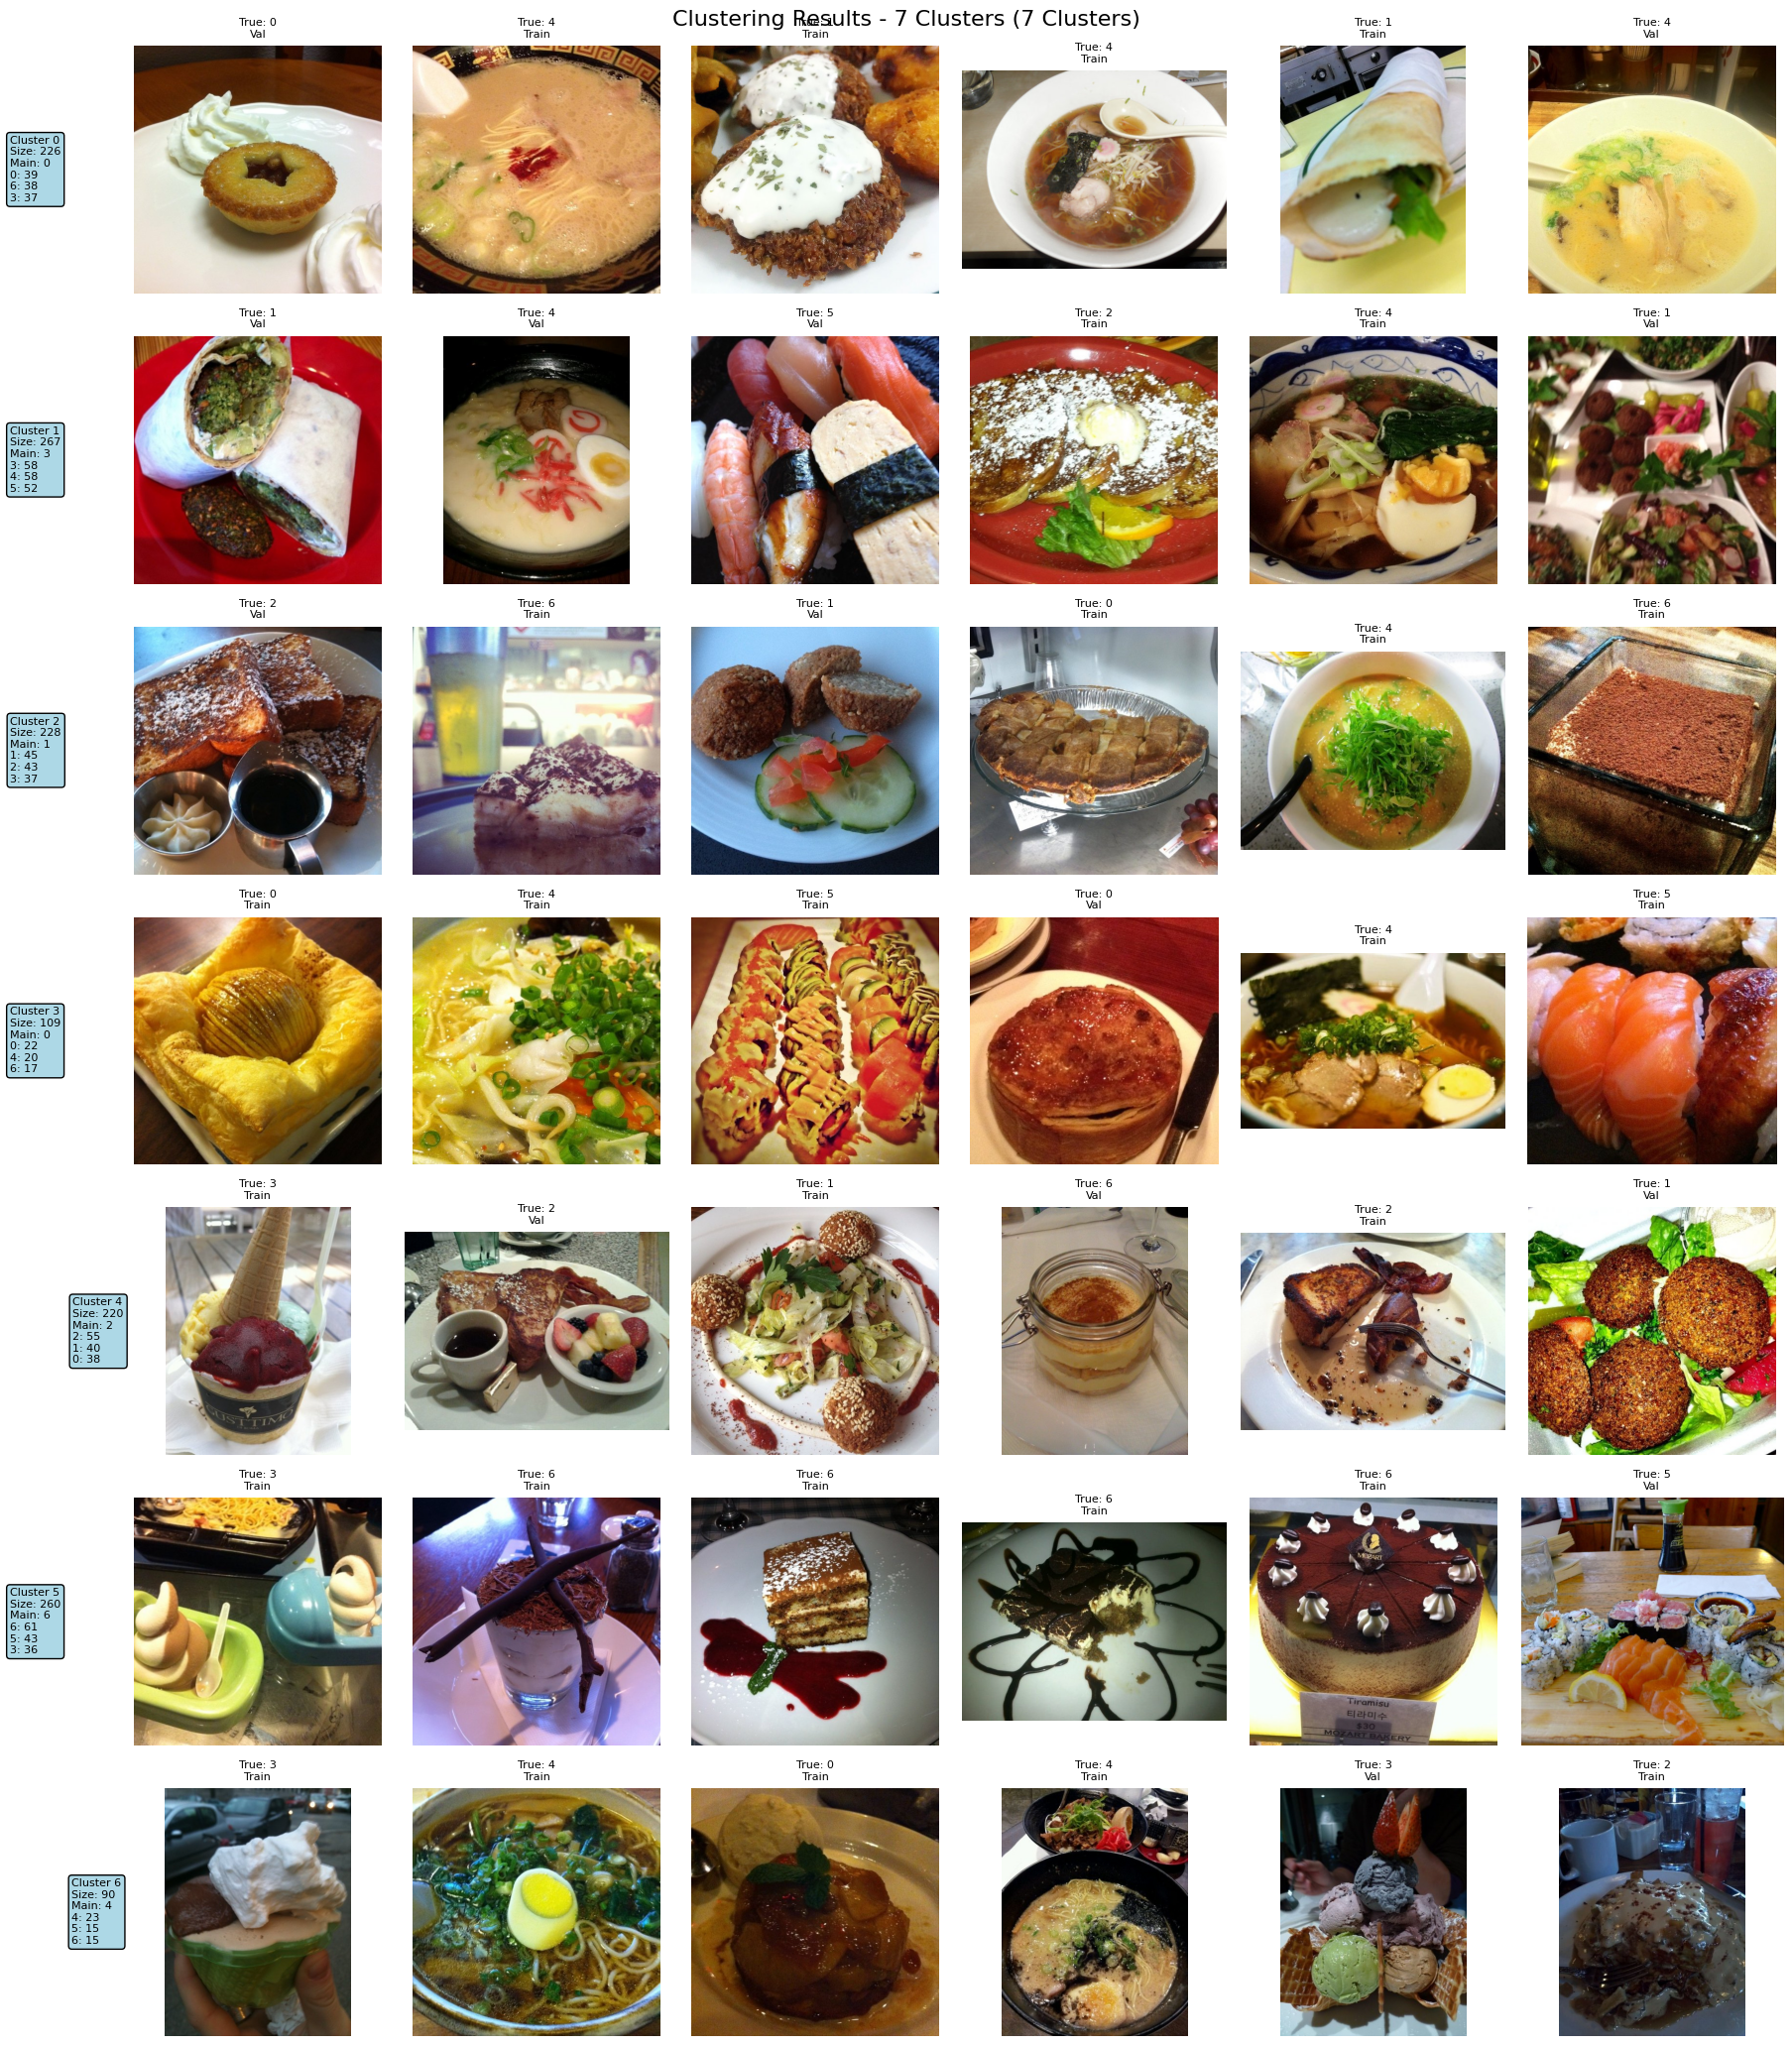

In [49]:
cluster_labels_7, kmeans_7 = perform_clustering_and_visualize(
    all_images_reduced, all_labels_combined, 7, "(7 Clusters)"
)

## 6. Try these:
- Experiment with different numbers of clusters for K-Means.
- Evaluate clustering quality using metrics like Silhouette Score or Adjusted Rand Index (if ground truth is used for evaluation).
- Try other clustering algorithms (e.g., DBSCAN, Agglomerative Clustering).
- Use the reduced features from different DR techniques as input to the clustering step to compare their impact.
- Build a supervised image classification model using these features or directly from the images using CNNs.